In [1]:
import warnings
import itertools
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [3]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)


1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


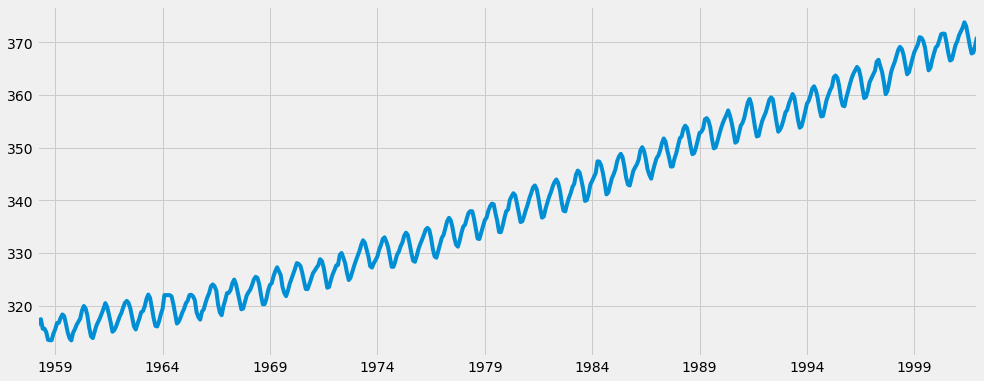

In [5]:
y.plot(figsize=(15, 6))
plt.show()

In [4]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

result = 10000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic = results.aic
            if aic < result:
                result = aic
                print(f'ARIMA{param}x{param_seasonal} - {aic}')
        except Exception as exc:
            continue



ARIMA(0, 0, 0)x(0, 0, 0, 12) - 7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12) - 6787.343624048814
ARIMA(0, 0, 0)x(0, 0, 2, 12) - 6027.256392967736
ARIMA(0, 0, 0)x(0, 1, 0, 12) - 1854.8282341412164
ARIMA(0, 0, 0)x(0, 1, 1, 12) - 1596.7111727639654
ARIMA(0, 0, 0)x(0, 1, 2, 12) - 1480.7910932052164
ARIMA(0, 0, 0)x(0, 2, 0, 12) - 1414.0325743420735
ARIMA(0, 0, 0)x(0, 2, 1, 12) - 1049.1885509674237
ARIMA(0, 0, 0)x(0, 2, 2, 12) - 1000.6304768422605
ARIMA(0, 0, 0)x(1, 1, 2, 12) - 998.6335105974491
ARIMA(0, 0, 0)x(2, 2, 1, 12) - 994.7689101025186
ARIMA(0, 0, 0)x(2, 2, 2, 12) - 994.7413526186624
ARIMA(0, 0, 1)x(0, 2, 1, 12) - 804.238683863604
ARIMA(0, 0, 1)x(0, 2, 2, 12) - 739.8218329772201
ARIMA(0, 0, 1)x(1, 1, 2, 12) - 734.9191875318372
ARIMA(0, 0, 1)x(2, 1, 2, 12) - 731.391687478472
ARIMA(0, 0, 2)x(0, 2, 1, 12) - 687.8114880230327
ARIMA(0, 0, 2)x(0, 2, 2, 12) - 604.7497090268023
ARIMA(0, 0, 2)x(1, 1, 2, 12) - 599.5998173468681
ARIMA(0, 0, 2)x(2, 1, 2, 12) - 599.0078334604405
ARIMA(0, 1, 0)x(

In [6]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3390      0.039     -8.653      0.000      -0.416      -0.262
ma.S.L12      -0.8567      0.046    -18.679      0.000      -0.947      -0.767
ma.S.L24      -0.0213      0.047     -0.451      0.652      -0.114       0.071
sigma2         0.0992      0.004     23.394      0.000       0.091       0.108


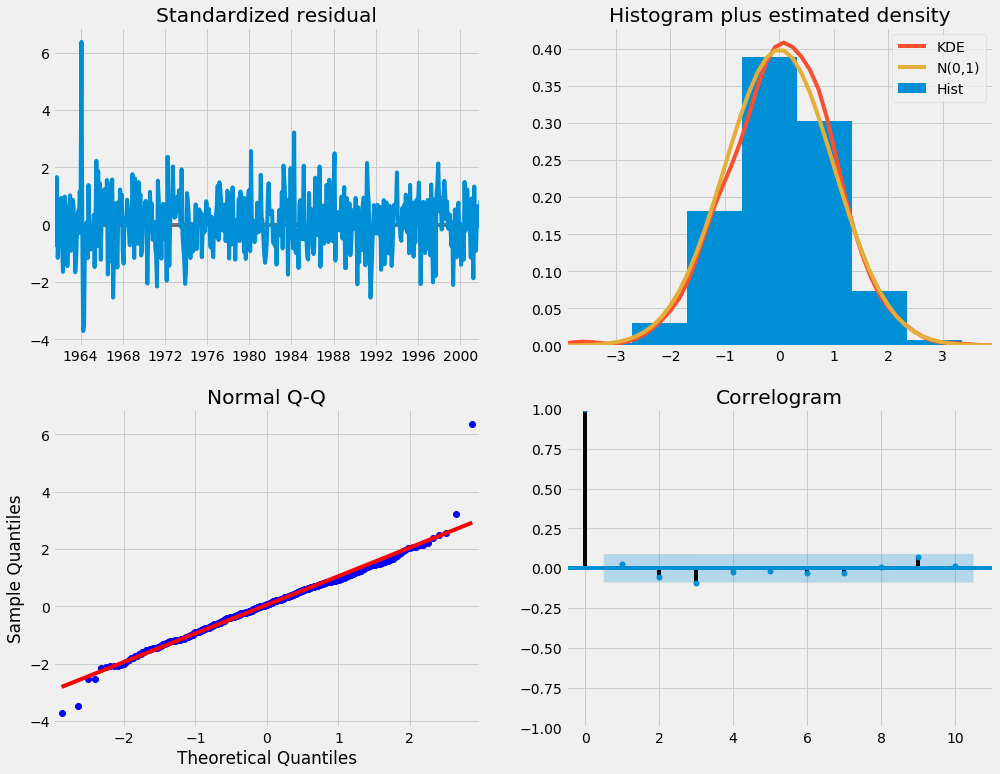

In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [14]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

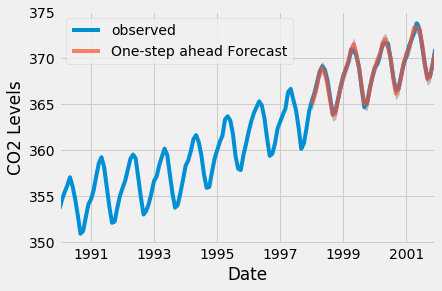

In [15]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [17]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

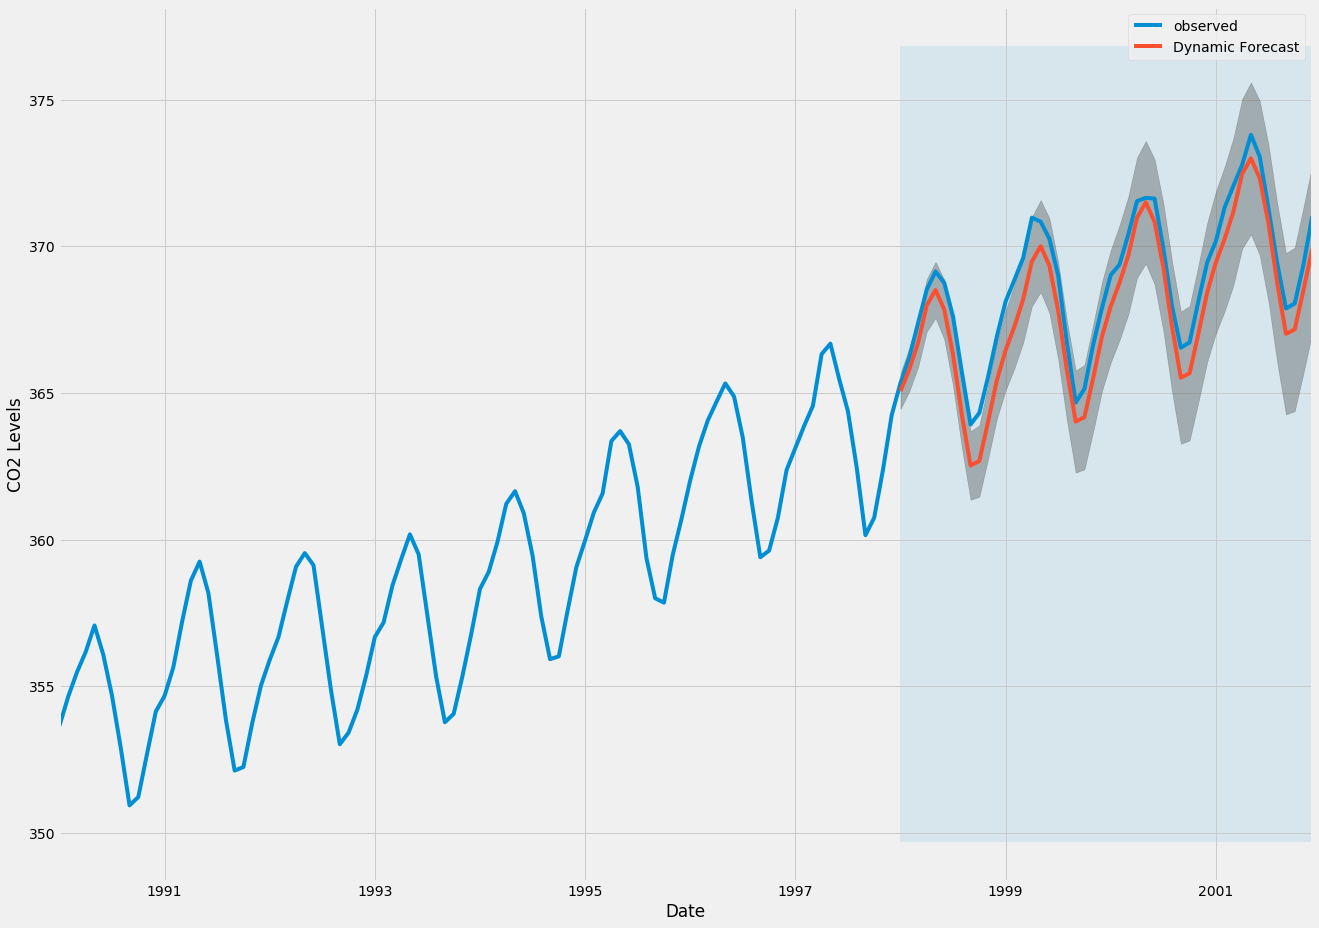

In [18]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [19]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [20]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

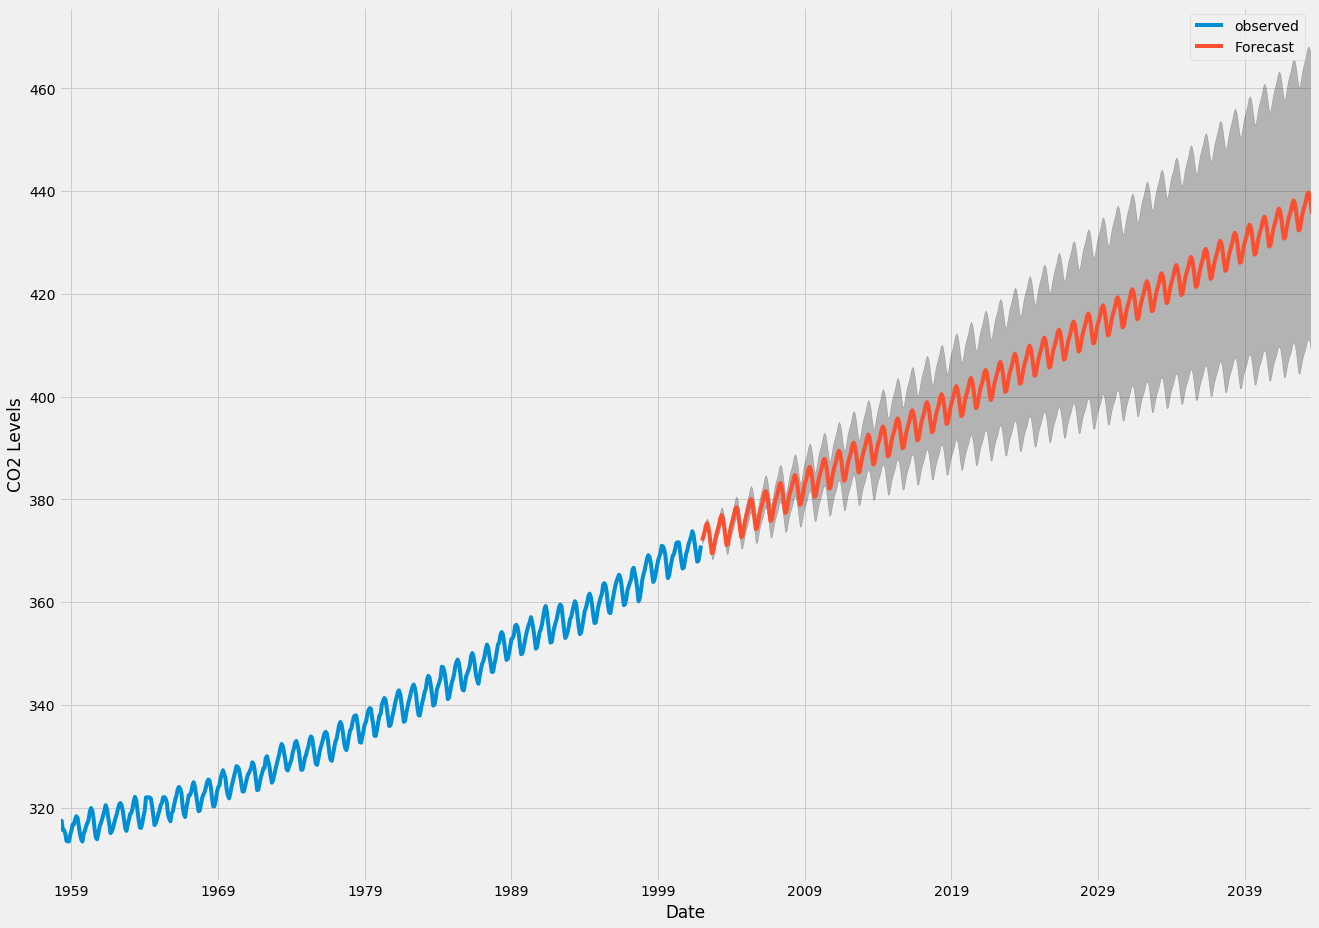

In [21]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()
